In [14]:
import os, shutil
import random
import gc  #Gabage collector for cleaning deleted data from memory

import cv2
import numpy as np
from glob import glob
from datetime import datetime

#Lets declare our image dimensions
#we are using coloured images. 
nrows = 64
ncolumns = 64
channels = 3  #change to 1 if you want to use grayscale image


#A function to read and process the images to an acceptable format for our model
def read_and_process_image(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels
        if 'Buy' in image:
            y.append(1)
        elif 'Sell' in image:
            y.append(2)
        else: # None
            y.append(3)
    
    return X, y



def get_data():

    train_dir = '/Volumes/LaCie/Trading System Database/Data/Chart Analysis/input/train'
    test_dir = '/Volumes/LaCie/Trading System Database/Data/Chart Analysis/input/test'

    # train_imgs = ['../input/train/{}'.format(i) for i in os.listdir(train_dir)]  #get full data set
    train_buys = ['/Volumes/LaCie/Trading System Database/Data/Chart Analysis/input/train/{}'.format(i) for i in os.listdir(train_dir) if 'Buy' in i]  #get buy images
    train_sells = ['/Volumes/LaCie/Trading System Database/Data/Chart Analysis/input/train/{}'.format(i) for i in os.listdir(train_dir) if 'Sell' in i]  #get sell images
    train_none = ['/Volumes/LaCie/Trading System Database/Data/Chart Analysis/input/train/{}'.format(i) for i in os.listdir(train_dir) if 'None' in i]  #get sell images

    test_imgs = ['/Volumes/LaCie/Trading System Database/Data/Chart Analysis/input/test/{}'.format(i) for i in os.listdir(test_dir)] #get test images

    train_imgs = train_buys[:15000] + train_sells[:15000] + train_none[:15000]  # slice the dataset and use 2000 in each class
    random.shuffle(train_imgs)  # shuffle it randomly

    #Clear list that are useless
    del train_buys
    del train_sells
    del train_none
    gc.collect()

    #get the train and label data
    X, y = read_and_process_image(train_imgs)

    del train_imgs
    gc.collect()
    #Convert list to numpy array
    X = np.array(X)
    y = np.array(y)

    #Lets split the data into train and test set
    from sklearn.model_selection import train_test_split
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=2)
    
#     print (test_imgs[:10])
    X, y = read_and_process_image(test_imgs)
    X_test = np.array(X)
    y_test = np.array(y)

    #clear memory
    del X
    del y
    del test_imgs
    gc.collect()


    return X_train, y_train, X_valid, y_valid, X_test, y_test


In [15]:
X_train, y_train, X_valid, y_valid, X_test, y_test = get_data()


In [16]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training example
n_train = X_train.shape[0]

# TODO: Number of validation example
n_validation = X_valid.shape[0]

# TODO: Number of testing example.
n_test = X_test.shape[0]

# TODO: What's the shape of an input image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 17789
Number of testing examples = 2224
Image data shape = (64, 64, 3)
Number of classes = 3


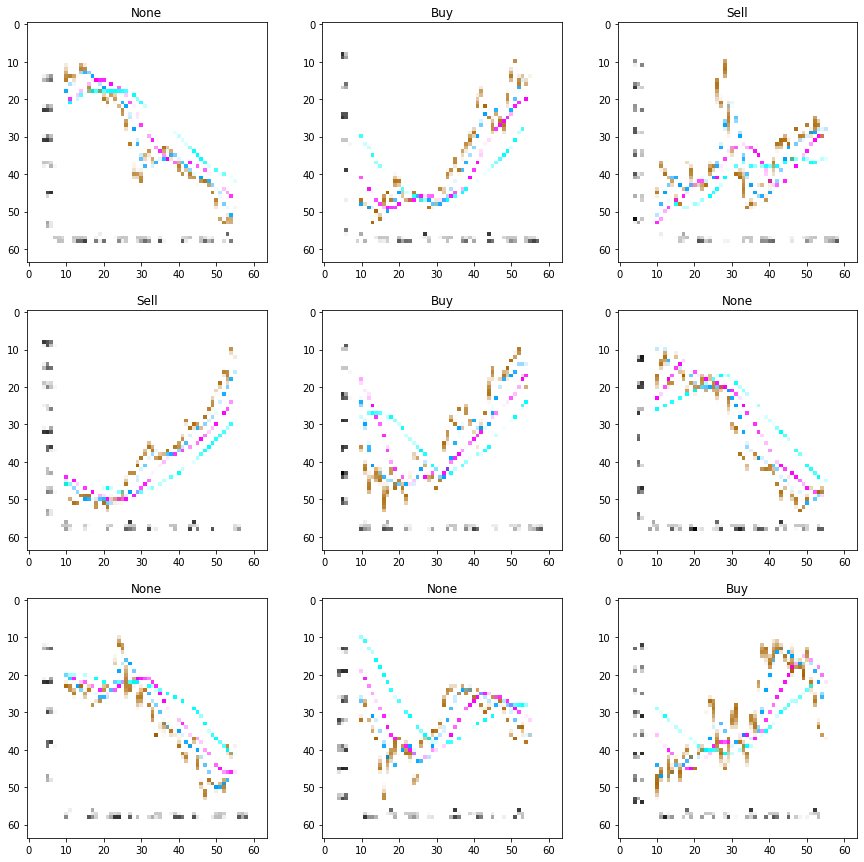

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import random
from PIL import Image, ImageEnhance
# Visualizations will be shown in the notebook.
%matplotlib inline

# Load name of id
with open("trafsig/signnames.csv", "r") as f:
    signnames = f.read()
id_to_name = { int(line.split(",")[0]):line.split(",")[1] for line in signnames.split("\n")[1:] if len(line) > 0}

graph_size = 3
random_index_list = [random.randint(0, X_train.shape[0]) for _ in range(graph_size * graph_size)]
fig = plt.figure(figsize=(15, 15))
for i, index in enumerate(random_index_list):
    a=fig.add_subplot(graph_size, graph_size, i+1)
    #im = Image.fromarray(np.rollaxis(X_train[index] * 255, 0,3))
    imgplot = plt.imshow(X_train[index])
    # Plot some images
    a.set_title('%s' % id_to_name[y_train[index]])

plt.show()

In [17]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.image import ImageDataGenerator


X_train = X_train / 255
X_valid = X_valid / 255
X_test = X_test / 255

train_datagen = ImageDataGenerator()
inference_datagen = ImageDataGenerator()
train_datagen.fit(X_train)
inference_datagen.fit(X_valid)
inference_datagen.fit(X_test)


In [7]:
import numpy as np
import tensorflow as tf

def conv_caps_layer(input_layer, capsules_size, nb_filters, kernel, stride=2):
    """
        Capsule layer for the convolutional inputs
        **input:
            *input_layer: (Tensor)
            *capsule_numbers: (Integer) the number of capsule in this layer.
            *kernel_size: (Integer) Size of the kernel for each filter.
            *stride: (Integer) 2 by default
    """
    # "In convolutional capsule layers each unit in a capsule is a convolutional unit.
    # Therefore, each capsule will output a grid of vectors rather than a single vector output."
    capsules = tf.contrib.layers.conv2d(
        input_layer, nb_filters * capsules_size, kernel, stride, padding="VALID")
    # conv shape: [?, kernel, kernel, nb_filters]
    shape = capsules.get_shape().as_list()
    capsules = tf.reshape(capsules, shape=(-1, np.prod(shape[1:3]) * nb_filters, capsules_size, 1))
    # capsules shape: [?, nb_capsules, capsule_size, 1]
    return squash(capsules)

def routing(u_hat, b_ij, nb_capsules, nb_capsules_p, iterations=4):
    """
        Routing algorithm

        **input:
            *u_hat: Dot product (weights between previous capsule and current capsule)
            *b_ij: the log prior probabilities that capsule i should be coupled to capsule j
            *nb_capsules_p: Number of capsule in the previous layer
            *nb_capsules: Number of capsule in this layer
    """
    # Start the routing algorithm
    for it in range(iterations):
        with tf.variable_scope('routing_' + str(it)):
            # Line 4 of algo
            # probabilities that capsule i should be coupled to capsule j.
            # c_ij:  [nb_capsules_p, nb_capsules, 1, 1]
            c_ij = tf.nn.softmax(b_ij, dim=2)

            # Line 5 of algo
            # c_ij:  [      nb_capsules_p, nb_capsules, 1,         1]
            # u_hat: [?,    nb_capsules_p, nb_capsules, len_v_j,   1]
            s_j = tf.multiply(c_ij, u_hat)
            # s_j: [?, nb_capsules_p, nb_capsules, len_v_j, 1]
            s_j = tf.reduce_sum(s_j, axis=1, keep_dims=True)
            # s_j: [?, 1, nb_capsules, len_v_j, 1)

            # line 6:
            # squash using Eq.1,
            v_j = squash(s_j)
            # v_j: [1, 1, nb_capsules, len_v_j, 1)

            # line 7:
            # Frist reshape & tile v_j
            # [? ,  1,              nb_capsules,    len_v_j, 1] ->
            # [?,   nb_capsules_p,  nb_capsules,    len_v_j, 1]
            v_j_tiled = tf.tile(v_j, [1, nb_capsules_p, 1, 1, 1])
            # u_hat:    [?,             nb_capsules_p, nb_capsules, len_v_j, 1]
            # v_j_tiled [1,             nb_capsules_p, nb_capsules, len_v_j, 1]
            u_dot_v = tf.matmul(u_hat, v_j_tiled, transpose_a=True)
            # u_produce_v: [?, nb_capsules_p, nb_capsules, 1, 1]
            b_ij += tf.reduce_sum(u_dot_v, axis=0, keep_dims=True)
            #b_ih: [1, nb_capsules_p, nb_capsules, 1, 1]

    return tf.squeeze(v_j, axis=1)

def fully_connected_caps_layer(input_layer, capsules_size, nb_capsules, iterations=4):
    """
        Second layer receiving inputs from all capsules of the layer below
            **input:
                *input_layer: (Tensor)
                *capsules_size: (Integer) Size of each capsule
                *nb_capsules: (Integer) Number of capsule
                *iterations: (Integer) Number of iteration for the routing algorithm

            i refer to the layer below.
            j refer to the layer above (the current layer).
    """
    shape = input_layer.get_shape().as_list()
    # Get the size of each capsule in the previous layer and the current layer.
    len_u_i = np.prod(shape[2])
    len_v_j = capsules_size
    # Get the number of capsule in the layer bellow.
    nb_capsules_p = np.prod(shape[1])

    # w_ij: Used to compute u_hat by multiplying the output ui of a capsule in the layer below
    # with this matrix
    # [nb_capsules_p, nb_capsules, len_v_j, len_u_i]
    _init = tf.random_normal_initializer(stddev=0.01, seed=0)
    _shape = (nb_capsules_p, nb_capsules, len_v_j, len_u_i)
    
    w_ij = tf.get_variable('weight', shape=_shape, dtype=tf.float32, initializer=_init)

    # Adding one dimension to the input [batch_size, nb_capsules_p,    length(u_i), 1] ->
    #                                   [batch_size, nb_capsules_p, 1, length(u_i), 1]
    # To allow the next dot product
    input_layer = tf.reshape(input_layer, shape=(-1, nb_capsules_p, 1, len_u_i, 1))
    input_layer = tf.tile(input_layer, [1, 1, nb_capsules, 1, 1])

    # Eq.2, calc u_hat
    # Prediction uj|i made by capsule i
    # w_ij:  [              nb_capsules_p, nb_capsules, len_v_j,  len_u_i, ]
    # input: [batch_size,   nb_capsules_p, nb_capsules, len_ui,   1]
    # u_hat: [batch_size,   nb_capsules_p, nb_capsules, len_v_j, 1]
    # Each capsule of the previous layer capsule layer is associated to a capsule of this layer
    u_hat = tf.einsum('abdc,iabcf->iabdf', w_ij, input_layer)

    # bij are the log prior probabilities that capsule i should be coupled to capsule j
    # [nb_capsules_p, nb_capsules, 1, 1]
    b_ij = tf.zeros(shape=[nb_capsules_p, nb_capsules, 1, 1], dtype=np.float32)

    return routing(u_hat, b_ij, nb_capsules, nb_capsules_p, iterations=iterations)

def squash(vector):
    """
        Squashing function corresponding to Eq. 1
        **input: **
            *vector
    """
    vector += 0.00001 # Workaround for the squashing function ...
    vec_squared_norm = tf.reduce_sum(tf.square(vector), -2, keep_dims=True)
    scalar_factor = vec_squared_norm / (1 + vec_squared_norm) / tf.sqrt(vec_squared_norm)
    vec_squashed = scalar_factor * vector  # element-wise
    return(vec_squashed)


In [8]:
import numpy as np
from trafsig.model_base import ModelBase
import tensorflow as tf

class ModelBuySell(ModelBase):
    """
        ModelBuySell.
        This class is used to create the conv graph using:
            Dynamic Routing Between Capsules
    """

    # Numbers of label to predict
    NB_LABELS = 3

    def __init__(self, model_name, output_folder):
        """
            **input:
                *model_name: (Integer) Name of this model
                *output_folder: Output folder to saved data (tensorboard, checkpoints)
        """
        ModelBase.__init__(self, model_name, output_folder=output_folder)

    def _build_inputs(self):
        """
            Build tensorflow inputs
            (Placeholder)
            **return: **
                *tf_images: Images Placeholder
                *tf_labels: Labels Placeholder
        """
        # Images 32*32*3
        tf_images = tf.placeholder(tf.float32, [None, 64, 64, 3], name='images')
        # Labels: [0, 1, 6, 20, ...]
        tf_labels = tf.placeholder(tf.int64, [None], name='labels')
        return tf_images, tf_labels

    def _build_main_network(self, images, conv_2_dropout):
        """
            This method is used to create the two convolutions and the CapsNet on the top
            **input:
                *images: Image PLaceholder
                *conv_2_dropout: Dropout value placeholder
            **return: **
                *Caps1: Output of first Capsule layer
                *Caps2: Output of second Capsule layer
        """
        # First BLock:
        # Layer 1: Convolution.
        shape = (self.h.conv_1_size, self.h.conv_1_size, 3, self.h.conv_1_nb)
        conv1 = self._create_conv(self.tf_images, shape, relu=True, max_pooling=False, padding='VALID')
        # Layer 2: Convolution.
        #shape = (self.h.conv_2_size, self.h.conv_2_size, self.h.conv_1_nb, self.h.conv_2_nb)
        #conv2 = self._create_conv(conv1, shape, relu=True, max_pooling=False, padding='VALID')
        conv1 = tf.nn.dropout(conv1, keep_prob=conv_2_dropout)

        # Create the first capsules layer
        caps1 = conv_caps_layer(
            input_layer=conv1,
            capsules_size=self.h.caps_1_vec_len,
            nb_filters=self.h.caps_1_nb_filter,
            kernel=self.h.caps_1_size)
        # Create the second capsules layer used to predict the output
        caps2 = fully_connected_caps_layer(
            input_layer=caps1,
            capsules_size=self.h.caps_2_vec_len,
            nb_capsules=self.NB_LABELS,
            iterations=self.h.routing_steps)

        return caps1, caps2

    def _build_decoder(self, caps2, one_hot_labels, batch_size):
        """
            Build the decoder part from the last capsule layer
            **input:
                *Caps2:  Output of second Capsule layer
                *one_hot_labels
                *batch_size
        """
        labels = tf.reshape(one_hot_labels, (-1, self.NB_LABELS, 1))
        # squeeze(caps2):   [?, len_v_j,    capsules_nb]
        # labels:           [?, NB_LABELS,  1] with capsules_nb == NB_LABELS
        mask = tf.matmul(tf.squeeze(caps2), labels, transpose_a=True)
        # Select the good capsule vector
        capsule_vector = tf.reshape(mask, shape=(batch_size, self.h.caps_2_vec_len))
        # capsule_vector: [?, len_v_j]

        # Reconstruct image
        fc1 = tf.contrib.layers.fully_connected(capsule_vector, num_outputs=400)
        fc1 = tf.reshape(fc1, shape=(batch_size, 5, 5, 16))
        upsample1 = tf.image.resize_nearest_neighbor(fc1, (8, 8))
        conv1 = tf.layers.conv2d(upsample1, 4, (3,3), padding='same', activation=tf.nn.relu)

        upsample2 = tf.image.resize_nearest_neighbor(conv1, (16, 16))
        conv2 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)

        upsample3 = tf.image.resize_nearest_neighbor(conv2, (32, 32))
        conv3 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)

        upsample4 = tf.image.resize_nearest_neighbor(conv2, (64, 64))
        conv6 = tf.layers.conv2d(upsample4, 16, (3,3), padding='same', activation=tf.nn.relu)

        #upsample5 = tf.image.resize_nearest_neighbor(conv2, (192, 192))
        #conv6 = tf.layers.conv2d(upsample5, 16, (3,3), padding='same', activation=tf.nn.relu)


        # 3 channel for RGG
        logits = tf.layers.conv2d(conv6, 3, (3,3), padding='same', activation=None)
        decoded = tf.nn.sigmoid(logits, name='decoded')
        tf.summary.image('reconstruction_img', decoded)

        return decoded

    def init(self):
        """
            Init the graph
        """
        # Get graph inputs
        self.tf_images, self.tf_labels = self._build_inputs()
        # Dropout inputs
        self.tf_conv_2_dropout = tf.placeholder(tf.float32, shape=(), name='conv_2_dropout')
        # Dynamic batch size
        batch_size = tf.shape(self.tf_images)[0]
        # Translate labels to one hot array
        one_hot_labels = tf.one_hot(self.tf_labels, depth=self.NB_LABELS)
        # Create the first convolution and the CapsNet
        self.tf_caps1, self.tf_caps2 = self._build_main_network(self.tf_images, self.tf_conv_2_dropout)

        # Build the images reconstruction
        self.tf_decoded = self._build_decoder(self.tf_caps2, one_hot_labels, batch_size)

        # Build the loss
        _loss = self._build_loss(
            self.tf_caps2, one_hot_labels, self.tf_labels, self.tf_decoded, self.tf_images)
        (self.tf_loss_squared_rec, self.tf_margin_loss_sum, self.tf_predicted_class,
         self.tf_correct_prediction, self.tf_accuracy, self.tf_loss, self.tf_margin_loss,
         self.tf_reconstruction_loss) = _loss

        # Build optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=self.h.learning_rate)
        self.tf_optimizer = optimizer.minimize(self.tf_loss, global_step=tf.Variable(0, trainable=False))

        # Log value into tensorboard
        tf.summary.scalar('margin_loss', self.tf_margin_loss)
        tf.summary.scalar('accuracy', self.tf_accuracy)
        tf.summary.scalar('total_loss', self.tf_loss)
        tf.summary.scalar('reconstruction_loss', self.tf_reconstruction_loss)

        self.tf_test = tf.random_uniform([2], minval=0, maxval=None, dtype=tf.float32, seed=None, name="tf_test")

        self.init_session()


    def _build_loss(self, caps2, one_hot_labels, labels, decoded, images):
        """
            Build the loss of the graph
        """
        # Get the length of each capsule
        capsules_length = tf.sqrt(tf.reduce_sum(tf.square(caps2), axis=2, keep_dims=True))

        max_l = tf.square(tf.maximum(0., 0.9 - capsules_length))
        max_l = tf.reshape(max_l, shape=(-1, self.NB_LABELS))
        max_r = tf.square(tf.maximum(0., capsules_length - 0.1))
        max_r = tf.reshape(max_r, shape=(-1, self.NB_LABELS))
        t_c = one_hot_labels
        m_loss = t_c * max_l + 0.5 * (1 - t_c) * max_r
        margin_loss_sum = tf.reduce_sum(m_loss, axis=1)
        margin_loss = tf.reduce_mean(margin_loss_sum)

        # Reconstruction loss
        loss_squared_rec = tf.square(decoded - images)
        reconstruction_loss = tf.reduce_mean(loss_squared_rec)

        # 3. Total loss
        loss = margin_loss + (0.0005 * reconstruction_loss)

        # Accuracy
        predicted_class = tf.argmax(capsules_length, axis=1)
        predicted_class = tf.reshape(predicted_class, [tf.shape(capsules_length)[0]])
        correct_prediction = tf.equal(predicted_class, labels)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        return (loss_squared_rec, margin_loss_sum, predicted_class, correct_prediction, accuracy,
                loss, margin_loss, reconstruction_loss)

    def optimize(self, images, labels, tb_save=True):
        """
            Train the model
            **input: **
                *images: Image to train the model on
                *labels: True classes
                *tb_save: (Boolean) Log this optimization in tensorboard
            **return: **
                Loss: The loss of the model on this batch
                Acc: Accuracy of the model on this batch
        """
        tensors = [self.tf_optimizer, self.tf_margin_loss, self.tf_accuracy, self.tf_tensorboard]
        _, loss, acc, summary = self.sess.run(tensors,
            feed_dict={
            self.tf_images: images,
            self.tf_labels: labels,
            self.tf_conv_2_dropout: self.h.conv_2_dropout
        })

        if tb_save:
            # Write data to tensorboard
            self.train_writer.add_summary(summary, self.train_writer_it)
            self.train_writer_it += 1

        return loss, acc

    def evaluate(self, images, labels, tb_train_save=False, tb_test_save=False):
        """
            Evaluate dataset
            **input: **
                *images: Image to train the model on
                *labels: True classes
                *tb_train_save: (Boolean) Log this optimization in tensorboard under the train part
                *tb_test_save: (Boolean) Log this optimization in tensorboard under the test part
            **return: **
                Loss: The loss of the model on this batch
                Acc: Accuracy of the model on this batch
        """
        tensors = [self.tf_margin_loss, self.tf_accuracy, self.tf_tensorboard]
        loss, acc, summary = self.sess.run(tensors,
                feed_dict={
                self.tf_images: images,
                self.tf_labels: labels,
                self.tf_conv_2_dropout: 1.
            })

        if tb_test_save:
            # Write data to tensorboard
            self.test_writer.add_summary(summary, self.test_writer_it)
            self.test_writer_it += 1

        if tb_train_save:
            # Write data to tensorboard
            self.train_writer.add_summary(summary, self.train_writer_it)
            self.train_writer_it += 1

        return loss, acc

    def predict(self, images):
        """
            Method used to predict a class
            Return a softmax
            **input: **
                *images: Image to train the model on
            **return:
                *softmax: Softmax between all capsules
        """
        tensors = [self.tf_caps2]

        caps2 = self.sess.run(tensors,
            feed_dict={
            self.tf_images: images,
            self.tf_conv_2_dropout: 1.
        })[0]

        # tf.sqrt(tf.reduce_sum(tf.square(caps2), axis=2, keep_dims=True))
        caps2 = np.sqrt(np.sum(np.square(caps2), axis=2, keepdims=True))
        caps2 = np.reshape(caps2, (len(images), self.NB_LABELS))
        # softmax
        softmax = np.exp(caps2) / np.sum(np.exp(caps2), axis=1, keepdims=True)

        return softmax

    def reconstruction(self, images, labels):
        """
            Method used to get the reconstructions given a batch
            Return the result as a softmax
            **input: **
                *images: Image to train the model on
                *labels: True classes
        """
        tensors = [self.tf_decoded]

        decoded = self.sess.run(tensors,
            feed_dict={
            self.tf_images: images,
            self.tf_labels: labels,
            self.tf_conv_2_dropout: 1.
        })[0]

        return decoded

    def evaluate_dataset(self, images, labels, batch_size=10):
        """
            Evaluate a full dataset
            This method is used to fully evaluate the dataset batch per batch. Useful when
            the dataset can't be fit inside to the GPU.
            *input: **
                *images: Image to train the model on
                *labels: True classes
            *return: **
                *loss: Loss overall your dataset
                *accuracy: Accuracy overall your dataset
                *predicted_class: Predicted class
        """
        tensors = [self.tf_loss_squared_rec, self.tf_margin_loss_sum, self.tf_correct_prediction,
                   self.tf_predicted_class]

        loss_squared_rec_list = None
        margin_loss_sum_list = None
        correct_prediction_list = None
        predicted_class = None

        b = 0
        for batch in self.get_batches([images, labels], batch_size, shuffle=False):
            images_batch, labels_batch = batch
            loss_squared_rec, margin_loss_sum, correct_prediction, classes = self.sess.run(tensors,
                feed_dict={
                self.tf_images: images_batch,
                self.tf_labels: labels_batch,
                self.tf_conv_2_dropout: 1.
            })
            if loss_squared_rec_list is not None:
                predicted_class = np.concatenate((predicted_class, classes))
                loss_squared_rec_list = np.concatenate((loss_squared_rec_list, loss_squared_rec))
                margin_loss_sum_list = np.concatenate((margin_loss_sum_list, margin_loss_sum))
                correct_prediction_list = np.concatenate((correct_prediction_list, correct_prediction))
            else:
                predicted_class = classes
                loss_squared_rec_list = loss_squared_rec
                margin_loss_sum_list = margin_loss_sum
                correct_prediction_list = correct_prediction
            b += batch_size

        margin_loss = np.mean(margin_loss_sum_list)
        reconstruction_loss = np.mean(loss_squared_rec_list)
        accuracy = np.mean(correct_prediction_list)

        loss = margin_loss

        return loss, accuracy, predicted_class

In [9]:
model = ModelBuySell("TrafficSign", output_folder="/Volumes/LaCie/Trading System Database/Data/Chart Analysis/outputs")
# model.init()
# model.load('/Volumes/LaCie/Trading System Database/Data/Chart Analysis/outputs/checkpoints/transfig')

In [39]:
tf.reset_default_graph()

In [10]:
model.load('/Volumes/LaCie/Trading System Database/Data/Chart Analysis/outputs/checkpoints/2020-05-02 00-11-46')

ModelBase::Loading ckpt ...


From /Users/marsliu/Documents/GitHub/trading-system/notebooks/trafsig/model_base.py:292: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



From /Users/marsliu/Documents/GitHub/trading-system/notebooks/trafsig/model_base.py:294: The name tf.train.import_meta_graph is deprecated. Please use tf.compat.v1.train.import_meta_graph instead.



Instructions for updating:
Use standard file APIs to check for files with this prefix.


From /Users/marsliu/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /Volumes/LaCie/Trading System Database/Data/Chart Analysis/outputs/checkpoints/2020-05-02 00-11-46


Restoring parameters from /Volumes/LaCie/Trading System Database/Data/Chart Analysis/outputs/checkpoints/2020-05-02 00-11-46


From /Users/marsliu/Documents/GitHub/trading-system/notebooks/trafsig/model_base.py:297: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

ModelBase::Ckpt ready


From /Users/marsliu/Documents/GitHub/trading-system/notebooks/trafsig/model_base.py:332: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



From /Users/marsliu/Documents/GitHub/trading-system/notebooks/trafsig/model_base.py:337: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



From /Users/marsliu/Documents/GitHub/trading-system/notebooks/trafsig/model_base.py:343: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.



In [21]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

BATCH_SIZE = 50

# Utils method to print the current progression
def plot_progression(b, cost, acc, label): print(
    "[%s] Batch ID = %s, loss = %s, acc = %s" % (label, b, cost, acc))

# Training pipeline
b = 0
valid_batch = inference_datagen.flow(X_valid, y_valid, batch_size=BATCH_SIZE)
best_validation_loss = None
augmented_factor = 0.3
decrease_factor = 0.5
train_batches = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
#augmented_train_batches = train_datagen_augmented.flow(X_train, y_train, batch_size=BATCH_SIZE)

while True:
    x_batch, y_batch = next(train_batches)

    ### Training
    cost, acc = model.optimize(x_batch, y_batch)
    ### Validation
    x_batch, y_batch = next(valid_batch, None)
    # Retrieve the cost and acc on this validation batch and save it in tensorboard
    cost_val, acc_val = model.evaluate(x_batch, y_batch, tb_test_save=True)

    if b % 10 == 0: # Plot the last results
        plot_progression(b, cost, acc, "Train")
        plot_progression(b, cost_val, acc_val, "Validation")
    if b % 1000 == 0: # Test the model on all the validation
        print("Evaluate full validation dataset ...")
        loss, acc, _ = model.evaluate_dataset(X_valid, y_valid)
        print("Current loss: %s Best loss: %s" % (loss, best_validation_loss))
        plot_progression(b, loss, acc, "TOTAL Validation")
        if best_validation_loss is None or loss < best_validation_loss:
            best_validation_loss = loss
            now = datetime.today().strftime('%Y-%m-%d %H-%M-%S')
            model.save(name=now)
        augmented_factor = augmented_factor * decrease_factor
        print("Augmented Factor = %s" % augmented_factor)

    b += 1

[Train] Batch ID = 0, loss = 0.042502295, acc = 0.64
[Validation] Batch ID = 0, loss = 0.043261122, acc = 0.7
Evaluate full validation dataset ...


ModelBase::Saving model ...


Current loss: 0.045030616 Best loss: None
[TOTAL Validation] Batch ID = 0, loss = 0.045030616, acc = 0.6563063063063063


ModelBase::Model successfully saved here: /Volumes/LaCie/Trading System Database/Data/Chart Analysis/outputs/checkpoints/2020-05-02 10-33-51


Augmented Factor = 0.15
[Train] Batch ID = 10, loss = 0.048096314, acc = 0.54
[Validation] Batch ID = 10, loss = 0.06442972, acc = 0.62
[Train] Batch ID = 20, loss = 0.044856716, acc = 0.64
[Validation] Batch ID = 20, loss = 0.022962062, acc = 0.56
[Train] Batch ID = 30, loss = 0.04476647, acc = 0.64
[Validation] Batch ID = 30, loss = 0.034003414, acc = 0.66
[Train] Batch ID = 40, loss = 0.038593683, acc = 0.74
[Validation] Batch ID = 40, loss = 0.05550206, acc = 0.68
[Train] Batch ID = 50, loss = 0.03653487, acc = 0.74
[Validation] Batch ID = 50, loss = 0.034741227, acc = 0.78
[Train] Batch ID = 60, loss = 0.03858782, acc = 0.62
[Validation] Batch ID = 60, loss = 0.052871622, acc = 0.66
[Train] Batch ID = 70, loss = 0.05352122, acc = 0.62
[Validation] Batch ID = 70, loss = 0.034244575, acc = 0.58
[Train] Batch ID = 80, loss = 0.037541226, acc = 0.72
[Validation] Batch ID = 80, loss = 0.029017013, acc = 0.72
[Train] Batch ID = 90, loss = 0.042603344, acc = 0.64
[Validation] Batch ID = 

ModelBase::Saving model ...


Current loss: 0.008964788 Best loss: 0.045030616
[TOTAL Validation] Batch ID = 1000, loss = 0.008964788, acc = 0.6581081081081082


ModelBase::Model successfully saved here: /Volumes/LaCie/Trading System Database/Data/Chart Analysis/outputs/checkpoints/2020-05-02 14-43-58


Augmented Factor = 0.075
[Train] Batch ID = 1010, loss = 0.009069542, acc = 0.56
[Validation] Batch ID = 1010, loss = 0.010322592, acc = 0.64


KeyboardInterrupt: 

In [22]:
loss, acc, predicted_class = model.evaluate_dataset(X_test, y_test)

print("Test Accuracy = ", acc)
print("Test Loss = ", loss)

Test Accuracy =  0.6076576576576577
Test Loss =  0.12213039


In [19]:
predict_dir_imgs = glob('/Volumes/LaCie/Trading System Database/Data/Chart Analysis/input/predict/*.png')

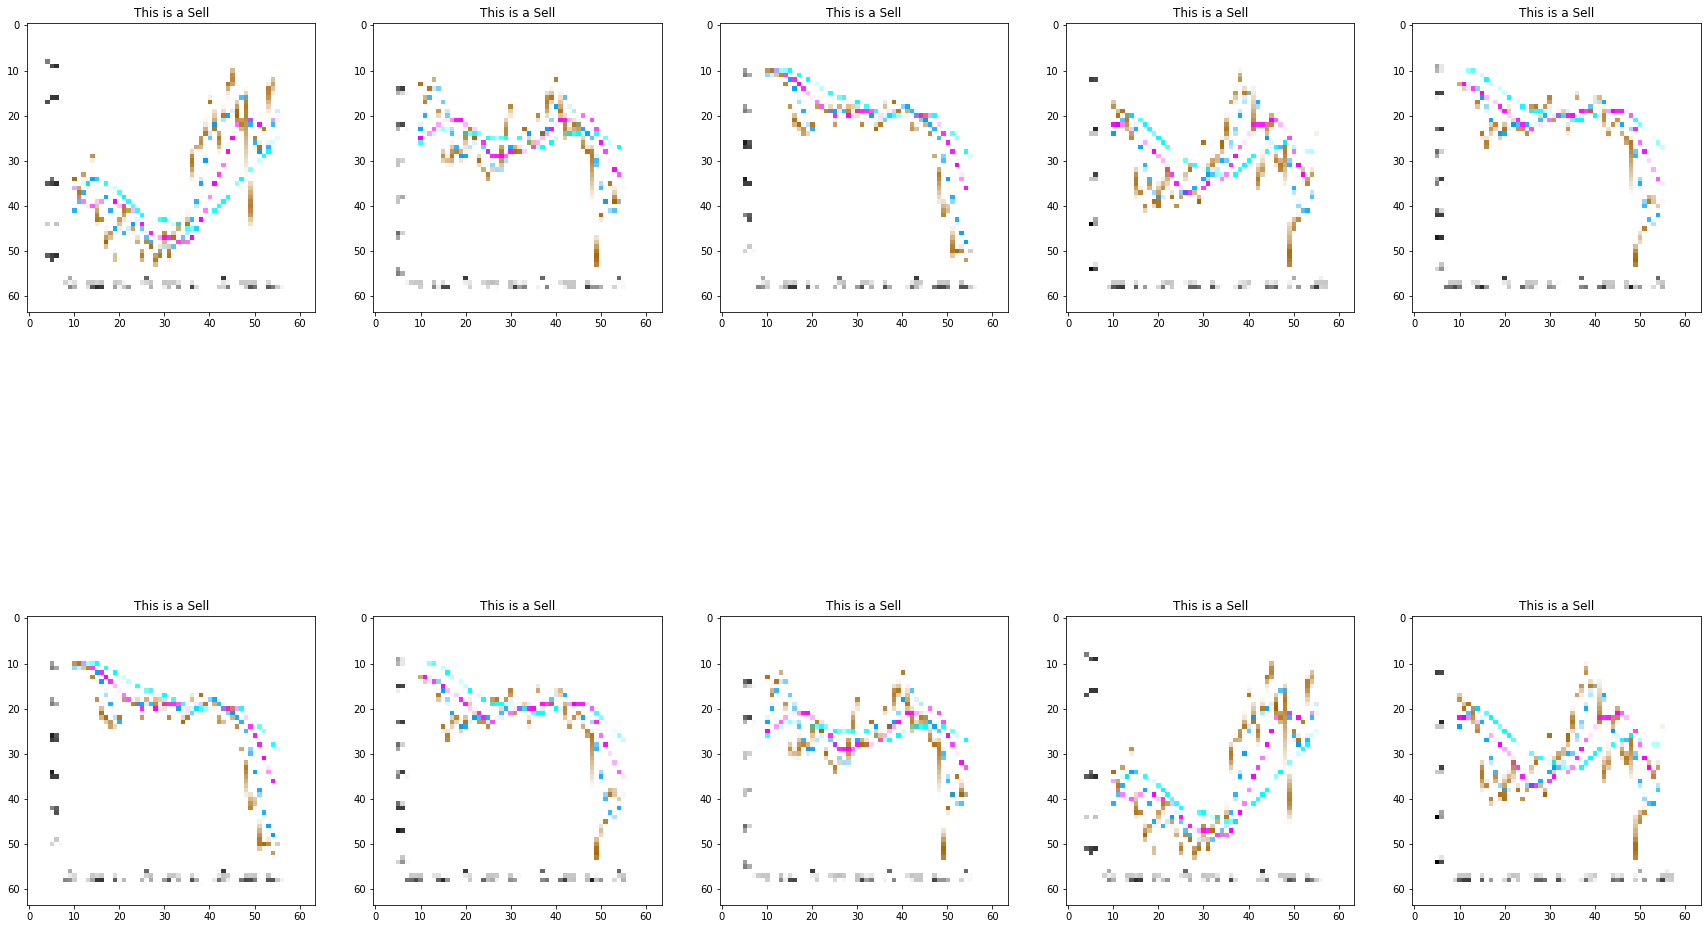

In [63]:
# Now lets predict on the first 10 Images of the test set
X_pred, y_pred = read_and_process_image(predict_dir_imgs) #Y_test in this case will be empty.
x = np.array(X_pred)
predict_datagen = ImageDataGenerator(rescale=1./255)

i = 0
columns = 5
text_labels = []
plt.figure(figsize=(30,20))
for batch in predict_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    if pred[0][0] > 0.5:
        text_labels.append('Buy')
    else:
        text_labels.append('Sell')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()

In [20]:
X_pred, y_pred = read_and_process_image(predict_dir_imgs) #Y_test in this case will be empty.
X_pred = np.array(X_pred)
X_pred = X_pred / 255
pred = model.predict(X_pred)

for i in range(len(pred)):
    no = predict_dir_imgs[i].split('predict/')[1].split('.png')[0]
    pred_i = np.where(pred[i] == np.amax(pred[i]))[0][0]
    pred_i = np.where(pred_i == 0, 'Buy', np.where(pred_i == 1, 'Sell', 'None'))
    print (no, pred_i)

0001.HK None
0005.HK None
0688.HK Sell
0700.HK Sell
1299.HK Sell


In [96]:
predict_dir_imgs[1].split('predict/')[1].split('.png')[0]

'0005.HK'

In [83]:
pred = model.predict(X_pred)[3]

In [84]:
np.where(pred == np.amax(pred))[0][0]

1

In [ ]:
y_pred

In [50]:
pred

array([[0.25573933, 0.33766434, 0.4065963 ]], dtype=float32)

In [10]:
import tensorflow as tf

tf.reset_default_graph()


In [7]:
X_pred, y_pred = read_and_process_image(predict_dir_imgs) #Y_test in this case will be empty.
x = np.array(X_pred)
x = x/255


inference_datagen = ImageDataGenerator()
inference_datagen.fit(x)



NameError: name 'ImageDataGenerator' is not defined